In [1]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
import os

# 1) 데이터 준비와 확인

In [2]:
#데이터 읽기
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- 데이터 중복, 결측치 제거, 토큰화, 불용어제거, 사전구성
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [36]:
#데이터 로더 구성
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, text_data, num_words = 10000):
    #데이터 중복, NaN 제거
    train_data.drop_duplicates(subset = 'document', inplace = True)
    train_data.dropna(subset = ['document'], inplace = True)
    
    test_data.drop_duplicates(subset = 'document', inplace = True)
    test_data.dropna(subset = ['document'], inplace = True)
    
    #한국어 토크나이저로 토큰화, 불용어 제거
    X_train = []
    for text in train_data['document']:
        tmp = tokenizer.morphs(text)
        tmp = [word for word in tmp if word not in stopwords]
        X_train.append(tmp)
    
    X_test = []
    for text in test_data['document']:
        tmp = tokenizer.morphs(text)
        tmp = [word for word in tmp if word not in stopwords]
        X_test.append(tmp)
        
    
    #사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    
    #텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(word_list):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in word_list]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [37]:
len(word_to_index)

9997

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정 -> 상위 95 %를 포함하는 길이 : 47로 설정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [38]:
#index to word, word to index 생성
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

In [39]:
index_to_word

{3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있'

In [40]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
word_to_index




{'': 4,
 '.': 5,
 '영화': 6,
 '다': 7,
 '고': 8,
 '하': 9,
 '을': 10,
 '보': 11,
 '..': 12,
 '게': 13,
 ',': 14,
 '!': 15,
 '지': 16,
 '있': 17,
 '없': 18,
 '?': 19,
 '좋': 20,
 '나': 21,
 '었': 22,
 '만': 23,
 '는데': 24,
 '너무': 25,
 '봤': 26,
 '적': 27,
 '안': 28,
 '정말': 29,
 '로': 30,
 '음': 31,
 '것': 32,
 '아': 33,
 '네요': 34,
 '재밌': 35,
 '어': 36,
 '같': 37,
 '점': 38,
 '지만': 39,
 '진짜': 40,
 '했': 41,
 '에서': 42,
 '기': 43,
 '네': 44,
 '않': 45,
 '거': 46,
 '았': 47,
 '수': 48,
 '되': 49,
 '면': 50,
 'ㅋㅋ': 51,
 '말': 52,
 '연기': 53,
 '인': 54,
 '주': 55,
 '내': 56,
 '최고': 57,
 '~': 58,
 '평점': 59,
 '이런': 60,
 '던': 61,
 '어요': 62,
 '할': 63,
 '왜': 64,
 '겠': 65,
 '1': 66,
 '스토리': 67,
 '해': 68,
 '습니다': 69,
 'ㅋㅋㅋ': 70,
 '...': 71,
 '드라마': 72,
 '생각': 73,
 '아니': 74,
 '더': 75,
 '그': 76,
 '싶': 77,
 '사람': 78,
 '듯': 79,
 '때': 80,
 '감동': 81,
 '함': 82,
 '배우': 83,
 '본': 84,
 '까지': 85,
 '뭐': 86,
 '알': 87,
 '만들': 88,
 '내용': 89,
 '볼': 90,
 '감독': 91,
 '보다': 92,
 '라': 93,
 '그냥': 94,
 '재미': 95,
 '시간': 96,
 '지루': 97,
 '중': 98,
 '재미있': 99,
 '년':

최대 문장 길이 :  116
최초 문장 길이 :  0
평균 문장 길이 :  15.96940191154864
상위 95%는 47 이하입니다.


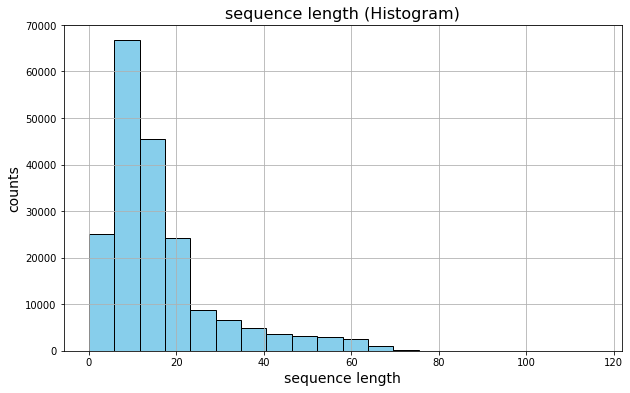

In [7]:
#데이터셋 내 문장 길이 분포
dataset = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in dataset]
num_tokens = np.array(num_tokens)
print('최대 문장 길이 : ',max(num_tokens)) #최대 문장 길이 116
print('최초 문장 길이 : ',min(num_tokens))
print('평균 문장 길이 : ',np.mean(num_tokens))
perc95_len = int(np.percentile(num_tokens, 95))
print(f"상위 95%는 {perc95_len} 이하입니다.")
maxlen = perc95_len
import matplotlib.pyplot as plt
# seq_len: 각 문장의 길이 리스트
plt.figure(figsize=(10, 6))
plt.hist(num_tokens, bins=20, color='skyblue', edgecolor='black')  # bin 수는 조절 가능
plt.title('sequence length (Histogram)', fontsize=16)
plt.xlabel('sequence length', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.grid(True)
plt.show()


In [8]:
#PAD, BOS, UNK, UNUSED 를 추가하는 작업을 합니다.
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.

<BOS>


In [58]:
#keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# padding 적용 (앞을 0으로 채우는 'pre' 방식, 필요시 'post'도 가능)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='pre')
X_test =tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='pre')

# 결과 확인
print("패딩 후 X_train shape:", X_train.shape)
print("패딩 후 X_test shape:", X_test.shape)

패딩 후 X_train shape: (146182, 47)
패딩 후 X_test shape: (49157, 47)


# 4) 모델 구성 및 validation set 구성
- CNN 기반 모델
- LSTM 기반 모델
- Transformer 기반 모델

In [10]:
#validation set 분리
val_split = int(len(X_train)* 0.3)
x_val = X_train[:val_split]
y_val = y_train[:val_split]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[val_split:]  
partial_y_train = y_train[val_split:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(102328, 47)
(102328,)
(43854, 47)
(43854,)


## Simple RNN

Epoch 1/20
200/200 [==============================] - 10s 43ms/step - loss: 0.5151 - accuracy: 0.7283 - val_loss: 0.3641 - val_accuracy: 0.8396
Epoch 2/20
200/200 [==============================] - 8s 41ms/step - loss: 0.3498 - accuracy: 0.8508 - val_loss: 0.3543 - val_accuracy: 0.8452
Epoch 3/20
200/200 [==============================] - 8s 42ms/step - loss: 0.3179 - accuracy: 0.8679 - val_loss: 0.3581 - val_accuracy: 0.8470
Epoch 4/20
200/200 [==============================] - 8s 42ms/step - loss: 0.2895 - accuracy: 0.8837 - val_loss: 0.3829 - val_accuracy: 0.8372
Epoch 5/20
200/200 [==============================] - 8s 42ms/step - loss: 0.2533 - accuracy: 0.9011 - val_loss: 0.3985 - val_accuracy: 0.8349
Epoch 6/20
200/200 [==============================] - 8s 42ms/step - loss: 0.2177 - accuracy: 0.9179 - val_loss: 0.4412 - val_accuracy: 0.8275
Epoch 7/20
200/200 [==============================] - 8s 42ms/step - loss: 0.1886 - accuracy: 0.9304 - val_loss: 0.4819 - val_accuracy: 0.817

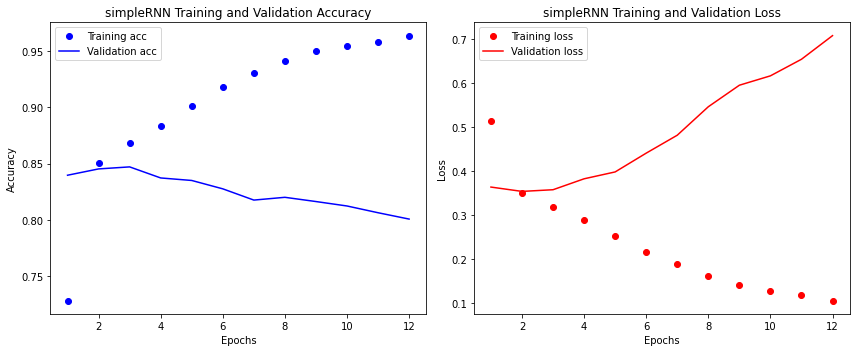

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
vocab_size = len(word_to_index) + 1    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터
model_rnn = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#과적합방지를 위한 early stopping
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10) 

epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,callbacks = [es],
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 🔹 1. 정확도 그래프
plt.subplot(1, 2, 1)  # (1행, 2열, 1번째)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('simpleRNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 2. 손실 그래프
plt.subplot(1, 2, 2)  # (1행, 2열, 2번째)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('simpleRNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## CNN 기반 모델(Conv1D, GlobalMaxPooling1D)

Epoch 1/20
200/200 [==============================] - 4s 7ms/step - loss: 0.4927 - accuracy: 0.7657 - val_loss: 0.3602 - val_accuracy: 0.8426
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3300 - accuracy: 0.8608 - val_loss: 0.3423 - val_accuracy: 0.8516
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2923 - accuracy: 0.8793 - val_loss: 0.3420 - val_accuracy: 0.8531
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2640 - accuracy: 0.8936 - val_loss: 0.3464 - val_accuracy: 0.8545
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2375 - accuracy: 0.9066 - val_loss: 0.3555 - val_accuracy: 0.8532
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2116 - accuracy: 0.9189 - val_loss: 0.3708 - val_accuracy: 0.8501
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1845 - accuracy: 0.9316 - val_loss: 0.3988 - val_accuracy: 0.8488
Epoch 

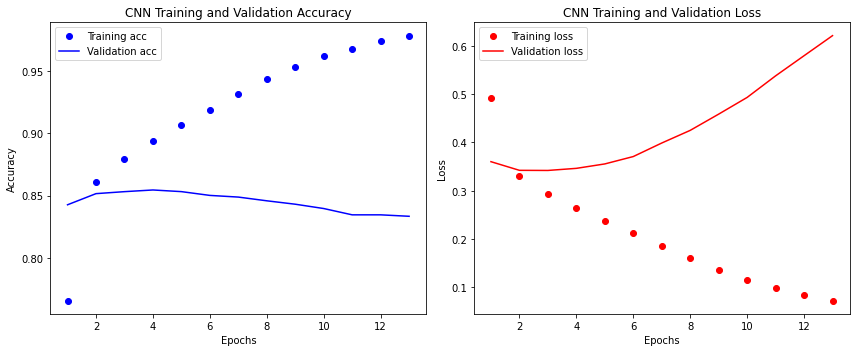

In [12]:
#모델 구성
vocab_size = len(word_to_index) + 1    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation = 'relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(16, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#과적합방지를 위한 early stopping
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10) 

epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,callbacks = [es],
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 🔹 1. 정확도 그래프
plt.subplot(1, 2, 1)  # (1행, 2열, 1번째)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 2. 손실 그래프
plt.subplot(1, 2, 2)  # (1행, 2열, 2번째)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## LSTM 모델

Epoch 1/20
200/200 [==============================] - 5s 13ms/step - loss: 0.4658 - accuracy: 0.7695 - val_loss: 0.3551 - val_accuracy: 0.8459
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 0.3372 - accuracy: 0.8559 - val_loss: 0.3575 - val_accuracy: 0.8430
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.3164 - accuracy: 0.8670 - val_loss: 0.3495 - val_accuracy: 0.8494
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.3072 - accuracy: 0.8724 - val_loss: 0.3550 - val_accuracy: 0.8470
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.2977 - accuracy: 0.8772 - val_loss: 0.3545 - val_accuracy: 0.8470
Epoch 6/20
200/200 [==============================] - 2s 10ms/step - loss: 0.2846 - accuracy: 0.8831 - val_loss: 0.3578 - val_accuracy: 0.8491
Epoch 7/20
200/200 [==============================] - 2s 10ms/step - loss: 0.2695 - accuracy: 0.8894 - val_loss: 0.3558 - val_accuracy: 0.8508

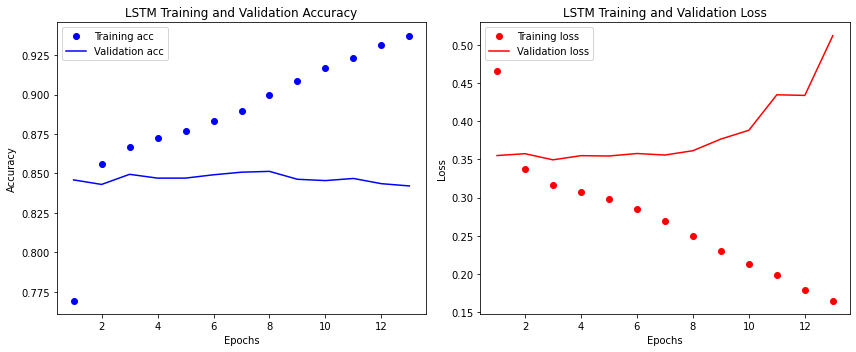

In [13]:
#lstm 기반 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
model_lstm = Sequential([
    Embedding(vocab_size, word_vector_dim, input_shape = (None,)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

#과적합 방지를 위한 early stopping
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, callbacks = [es],
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print('test_result: ',results)
history_dict = history.history
import matplotlib.pyplot as plt

# 먼저 history 객체로부터 정확도/손실 기록 불러오기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 에포크 수에 맞게 x축 범위 생성
epochs = range(1, len(acc) + 1)

# 시각화
plt.figure(figsize=(12, 5))

# 🔹 1. 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 2. 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 7) 학습된 Embedding 레이어 분석

In [65]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(model, word, word_to_index, index_to_word, top_n=10):
    # 임베딩 레이어 추출
    embedding_layer = model.layers[0]
    embedding_weights = embedding_layer.get_weights()[0]  # shape: (vocab_size, embedding_dim)

    # 단어 인덱스 확인
    if word not in word_to_index:
        print(f"'{word}' is not in the vocabulary.")
        return

    idx = word_to_index[word]
    target_vector = embedding_weights[idx].reshape(1, -1)

    # 전체 코사인 유사도 계산
    similarities = cosine_similarity(target_vector, embedding_weights)[0]

    # 유사도 높은 상위 top_n 단어 인덱스 추출
    similar_idx = similarities.argsort()[::-1][1:top_n+1]  # 자기 자신 제외

    # 결과 출력
    print(f"Words most similar to '{word}':\n")
    for i in similar_idx:
        similar_word = index_to_word.get(i, "?")
        print(f"{similar_word:15} (score: {similarities[i]:.4f})")


In [71]:
print('simple_rnn  ')
find_similar_words(model_rnn, word='영화', word_to_index=word_to_index, index_to_word=index_to_word, top_n=10)
print('='*40)
print('cnn  ')
find_similar_words(model_cnn, word='영화', word_to_index=word_to_index, index_to_word=index_to_word, top_n=10)
print('='*40)
print('lstm ')
find_similar_words(model_lstm, word='영화', word_to_index=word_to_index, index_to_word=index_to_word, top_n=10)

simple_rnn  
Words most similar to '영화':

져서              (score: 0.7561)
보다              (score: 0.7013)
법칙              (score: 0.6883)
한편              (score: 0.6815)
재방              (score: 0.6597)
끝나              (score: 0.6407)
건가요             (score: 0.6362)
졌               (score: 0.6315)
.................. (score: 0.6164)
흡사              (score: 0.6147)
cnn  
Words most similar to '영화':

천국              (score: 0.7589)
순위              (score: 0.7538)
분명히             (score: 0.7531)
마블              (score: 0.7375)
밖엔              (score: 0.7364)
월드컵             (score: 0.7331)
준다              (score: 0.7307)
리라              (score: 0.7251)
야겠다             (score: 0.7208)
프랑스             (score: 0.7149)
lstm 
Words most similar to '영화':

열               (score: 0.7558)
강인              (score: 0.7335)
주도              (score: 0.6739)
힘               (score: 0.6709)
헌데              (score: 0.6659)
발랄              (score: 0.6585)
개웃              (score: 0.6573)
만든              (scor

# 8) 한국어 Word2Vec 임베딩을 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]

In [16]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
model_path = '/aiffel/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(model_path)  
vector = word2vec.wv['드라마']
vector

array([-0.20973422, -0.61096764, -0.9033131 ,  2.957383  ,  1.8569387 ,
        1.2706641 , -3.7683392 , -2.802115  , -0.7573312 ,  1.0417593 ,
       -3.6991544 , -1.2614148 , -1.5790688 , -4.00267   ,  4.5657935 ,
       -1.1776268 , -1.9514618 , -0.68296045, -0.572553  , -1.1169969 ,
        0.03167932,  1.6880232 , -1.0688471 ,  2.1305177 , -0.08913164,
       -1.8747901 , -2.118389  ,  3.6970801 , -1.2416158 , -0.68125457,
       -3.6551244 ,  3.292321  ,  3.5484762 ,  0.08252752,  2.6031404 ,
        4.5135202 ,  1.4255892 ,  0.47073746, -3.4152977 , -0.77570534,
        2.4108121 , -2.0590503 ,  1.2684485 ,  2.492074  ,  0.976352  ,
        2.8478534 ,  1.4469601 ,  2.914614  ,  2.215515  , -3.5052524 ,
       -1.0651278 , -2.7645462 ,  2.8813627 , -4.223422  , -1.2215286 ,
       -2.6441448 ,  4.1211653 , -1.6006311 , -0.6597083 , -0.6771537 ,
       -1.0426844 ,  3.6979783 ,  3.2398548 , -0.3411325 , -0.34871313,
        0.76309395, -2.778278  , -0.32589075, -0.9296699 , -1.31

In [45]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = word2vec.vector_size # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
# Word2Vec 객체에서 단어 벡터 접근은 .wv
for i in range(4, vocab_size):
    word = index_to_word.get(i)
    if word and word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]


In [54]:
from tensorflow.keras.initializers import Constant
import keras

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = word2vec.vector_size # 워드 벡터의 차원수

# 모델 구성
model_word2vec = keras.Sequential()
model_word2vec.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_word2vec.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_word2vec.add(keras.layers.Dense(16, activation='relu'))
model_word2vec.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_word2vec.summary()

#과적합 방지를 위한 early stopping
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
# 학습의 진행
model_word2vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model_word2vec.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,callbacks=[es],
                    validation_data=(x_val, y_val),
                    verbose=1)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 47, 100)           1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_14 (Dense)             (None, 16)                8208      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 2,263,649
Trainable params: 2,263,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
400/400 [==============================] - 20s 47ms/step - loss: 0.4520 - accuracy: 0.7835 - val_loss: 0.3626 - val_accuracy: 0.8383
Epoch 2/20
400/400 [==============================] - 18s 46ms/step - loss: 0.3232 - accuracy: 0.8

### word2vec 적용 Accuracy : 0.8530
- simple rnn accuracy: 0.7957
- cnn accuracy: 0.8274
- lstm accuracy: 0.8382

In [59]:
# 테스트셋을 통한 모델 평가 # 85% 이상
results = model_word2vec.evaluate(X_test, y_test, verbose=2)

print('test_result : ', results)

1537/1537 - 5s - loss: 0.8132 - accuracy: 0.8530
test_result :  [0.8131754398345947, 0.8530219793319702]


In [63]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


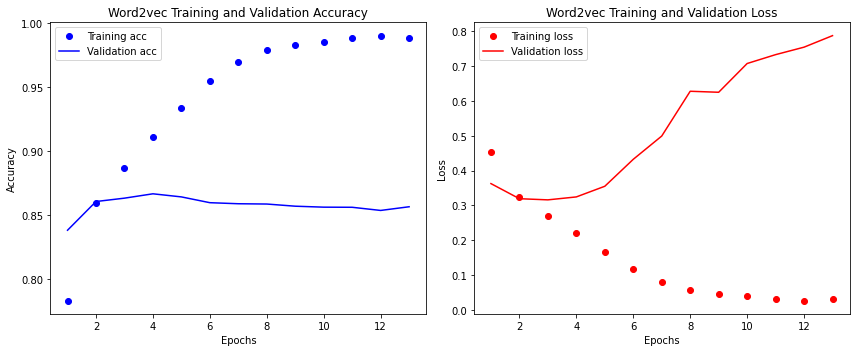

In [64]:
# 먼저 history 객체로부터 정확도/손실 기록 불러오기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 에포크 수에 맞게 x축 범위 생성
epochs = range(1, len(acc) + 1)

# 시각화
plt.figure(figsize=(12, 5))

# 🔹 1. 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Word2vec Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 2. 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Word2vec Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
